### Remap WOA18 to tx1_4

In [1]:
%matplotlib inline

In [2]:
import xarray as xr
import xesmf
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
fname = '../mesh/tx1_4_grid.nc'
ds_out = xr.open_dataset(fname).rename({'tlon': 'lon','tlat': 'lat', 'qlon': 'lon_b','qlat': 'lat_b',})
ds_out

<xarray.Dataset>
Dimensions:  (ny: 1080, nx: 1440, nxp: 1441, nyp: 1081)
Dimensions without coordinates: ny, nx, nxp, nyp
Data variables: (12/20)
    lon      (ny, nx) float64 ...
    lat      (ny, nx) float64 ...
    ulon     (ny, nxp) float64 ...
    ulat     (ny, nxp) float64 ...
    vlon     (nyp, nx) float64 ...
    vlat     (nyp, nx) float64 ...
    ...       ...
    tarea    (ny, nx) float64 ...
    tmask    (ny, nx) float64 ...
    angle    (ny, nx) float64 ...
    depth    (ny, nx) float64 ...
    ar       (ny, nx) float64 ...
    egs      (ny, nx) float64 ...
Attributes:
    Description:  CESM MOM6 1/4 degree grid
    Author:       Frank, Fred, Gustavo (gmarques@ucar.edu)
    Created:      2022-12-27T10:20:11.076318
    type:         Glogal 1/4 degree grid file

In [4]:
infile = '/glade/campaign/cgd/oce/datasets/obs/woa18/woa18_decav_merged_monthly_deep_04.nc'
ds_in = xr.open_dataset(infile)

In [5]:
def regrid_tracer(fld, ds_in, ds_out, method='bilinear'):

    regrid = xesmf.Regridder(
        ds_in,
        ds_out,
        method=method,
        periodic=True,
    )
    fld_out = regrid(ds_in[fld])#[0,0,:]#.where(ds_in.lat>ds_out.geolat.min())
    return fld_out

#### Potential temperature

In [6]:
temp = regrid_tracer('theta0', ds_in, ds_out)

##### Visual inspection
Make sure original and remapped plots look similar.

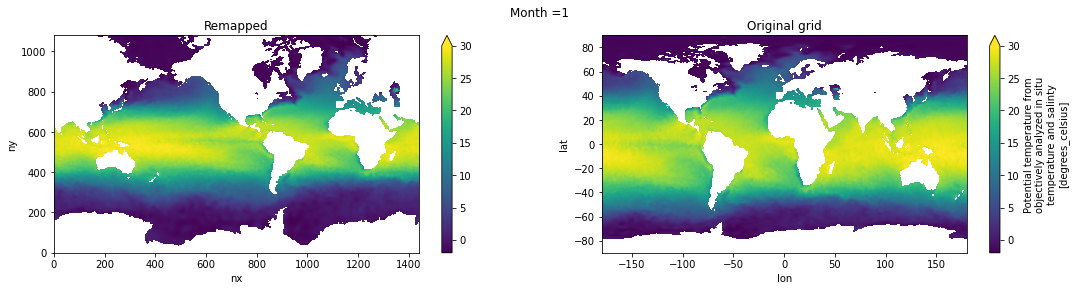

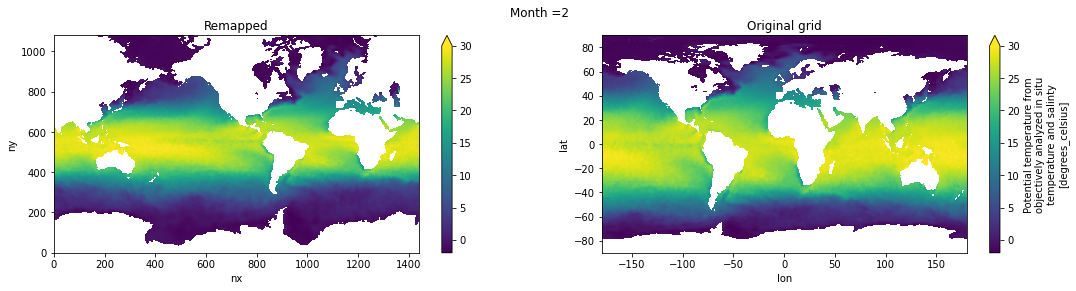

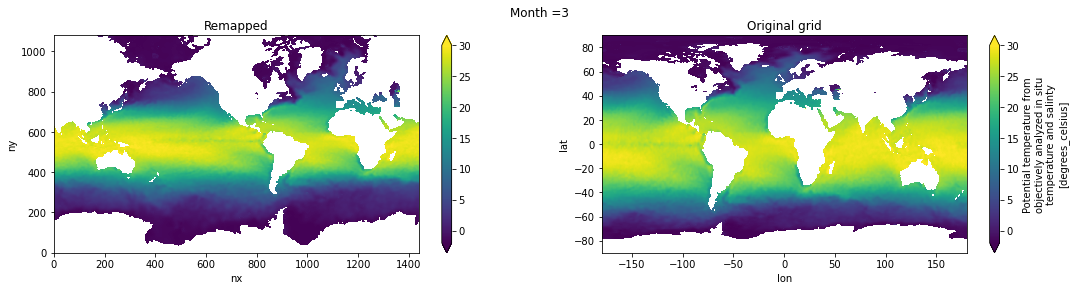

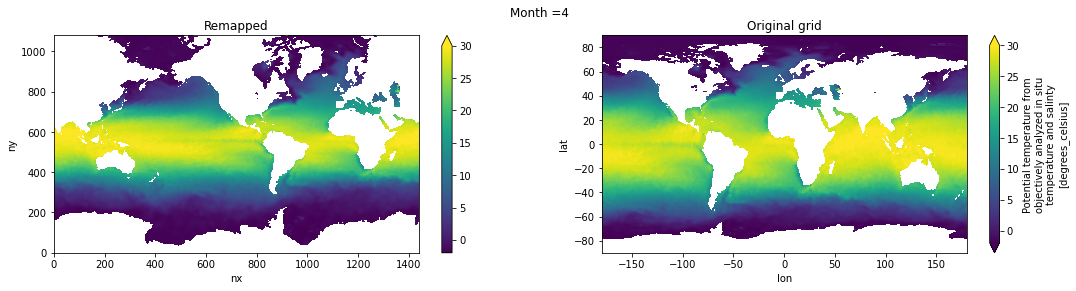

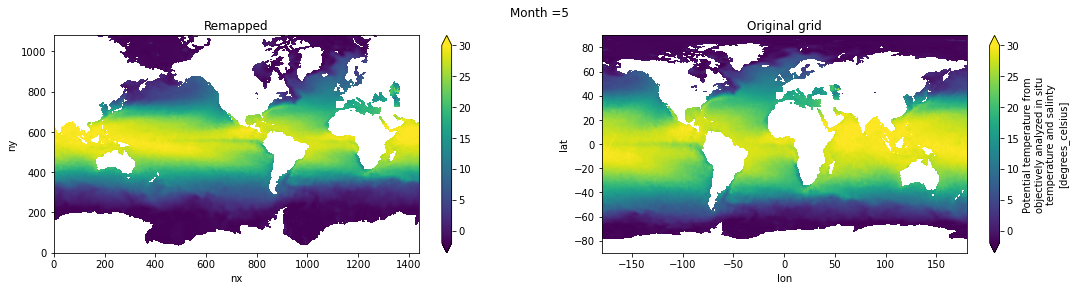

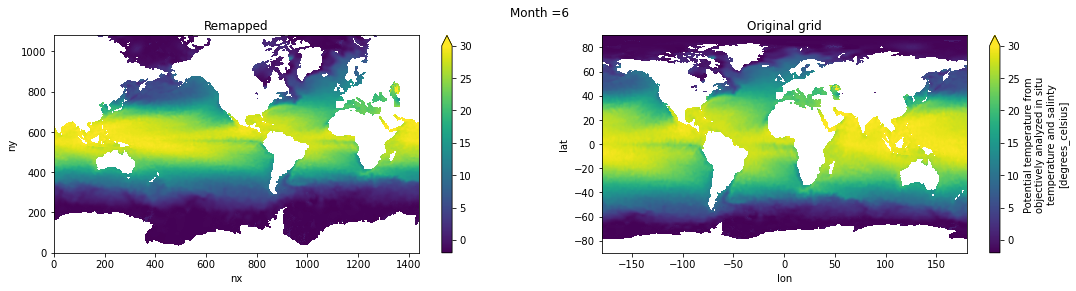

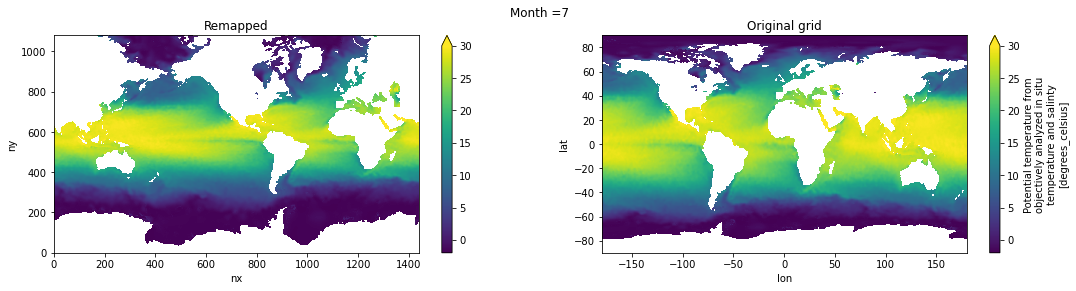

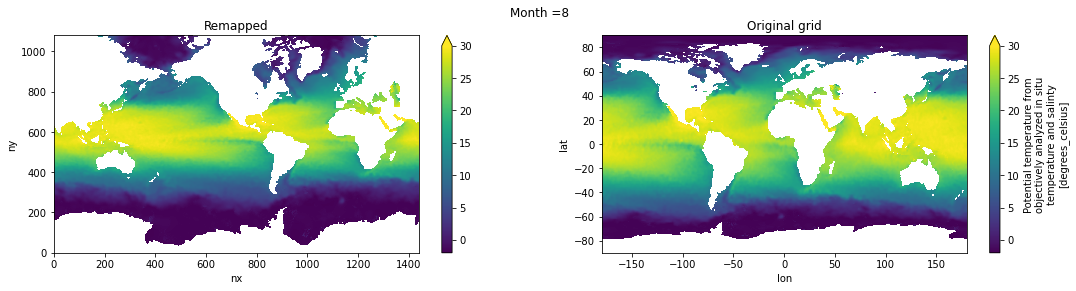

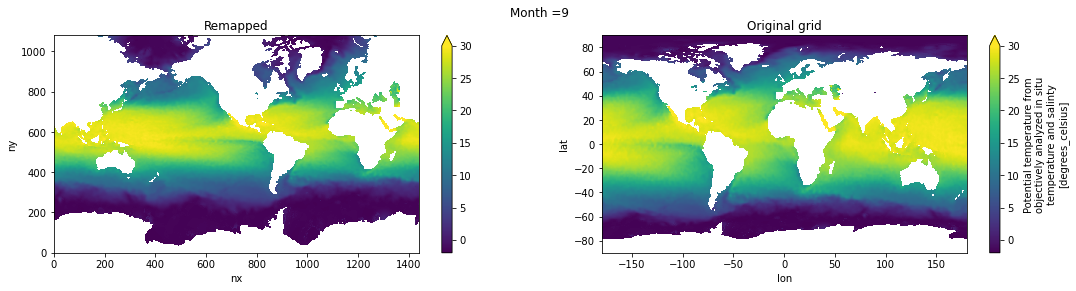

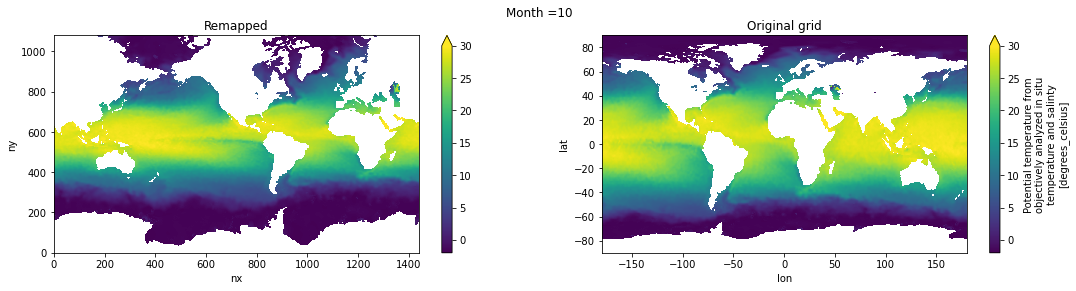

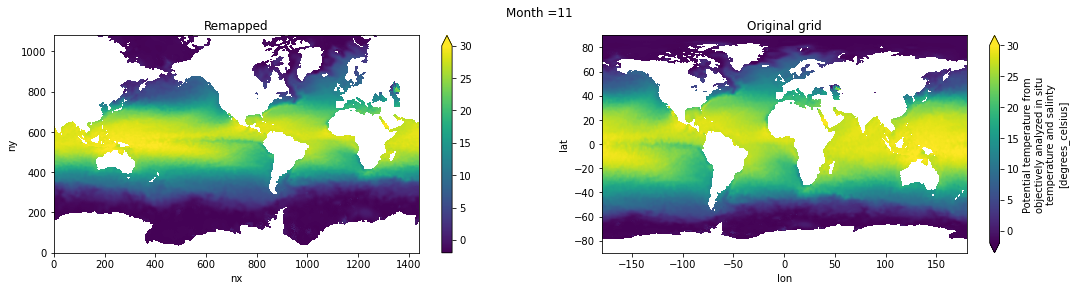

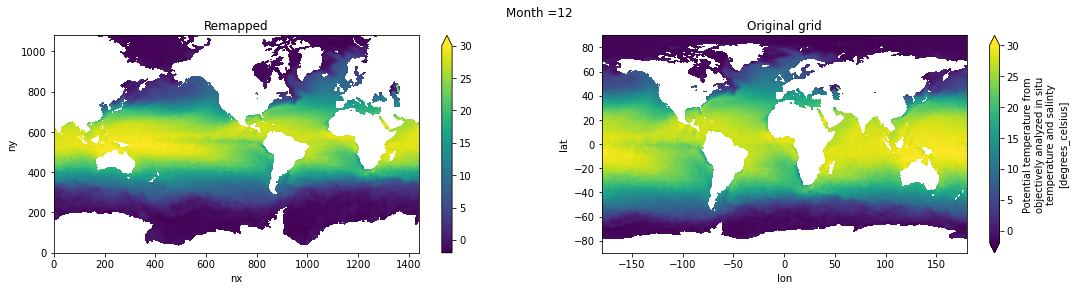

In [7]:
# visual inspection. Make sure original and remapped plots look similar
for t in range(len(temp.time)):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,4))
  temp[t,0,:,:].plot.pcolormesh(ax=axes[0], vmin=-2,vmax=30)
  ds_in['theta0'][t,0,:,:].plot.pcolormesh(ax=axes[1], vmin=-2,vmax=30)
  axes[0].set_title('Remapped')
  axes[1].set_title('Original grid')
  plt.suptitle('Month ='+ str(t+1))

#### Salinity

In [8]:
salt = regrid_tracer('s_an', ds_in, ds_out)

##### Visual inspection
Make sure original and remapped plots look similar.

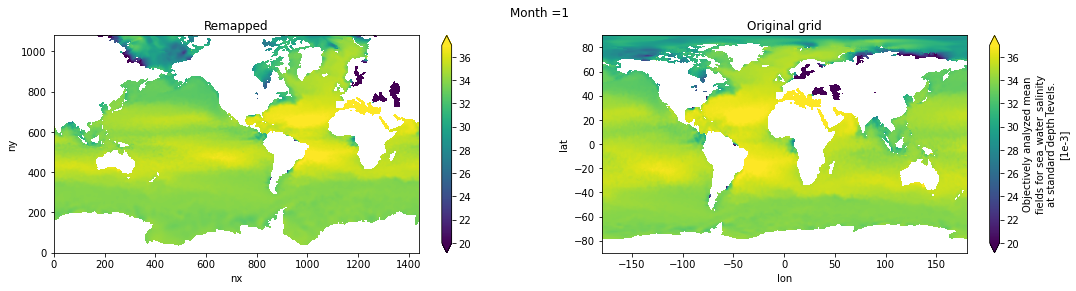

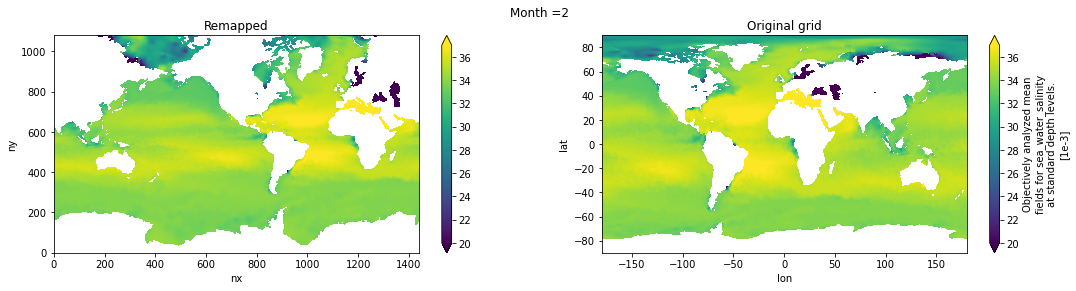

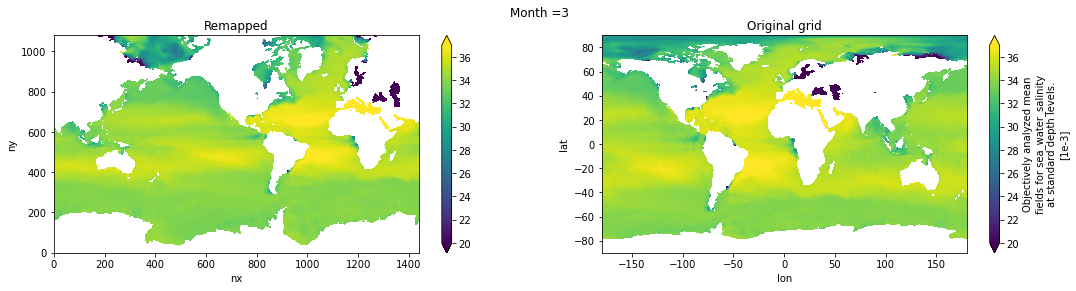

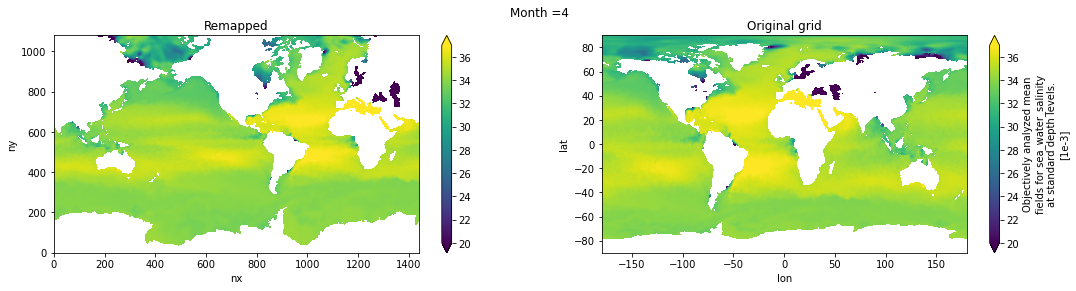

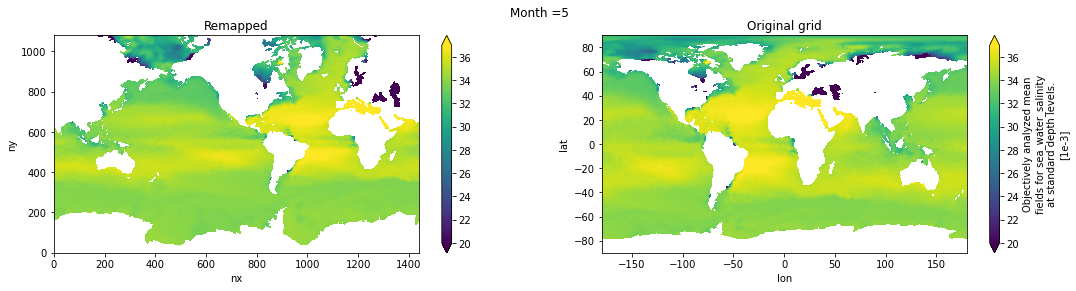

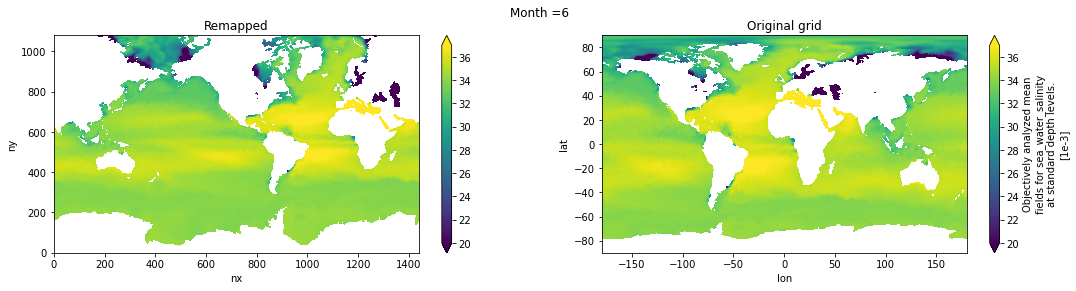

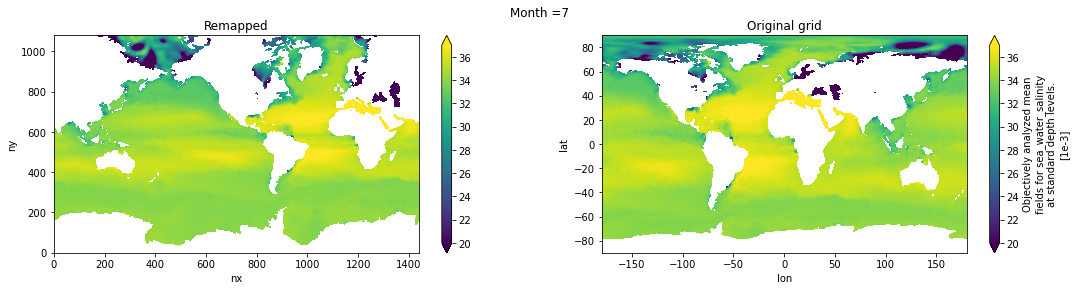

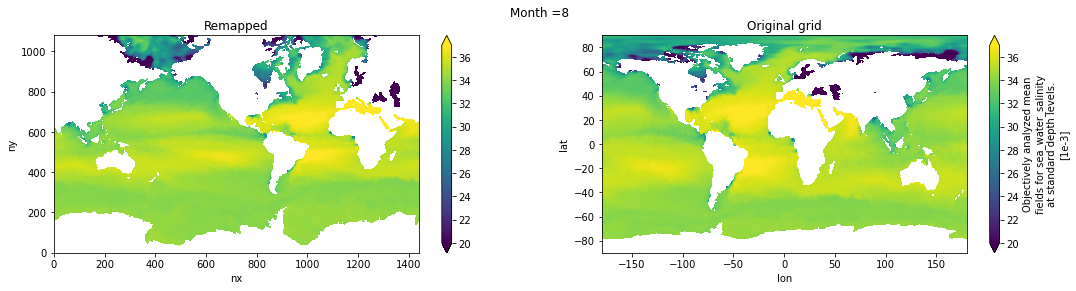

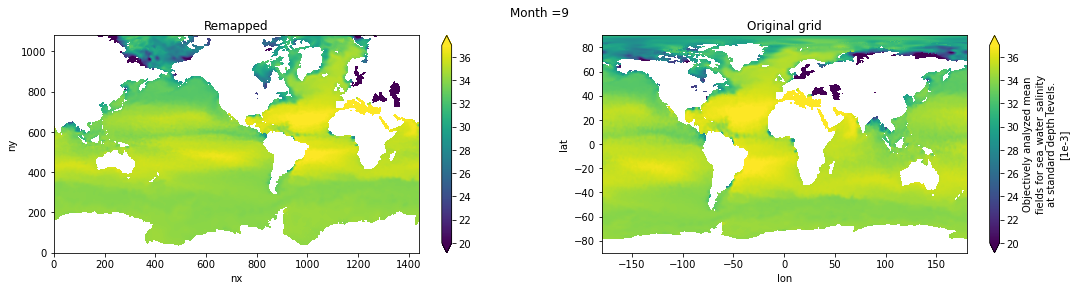

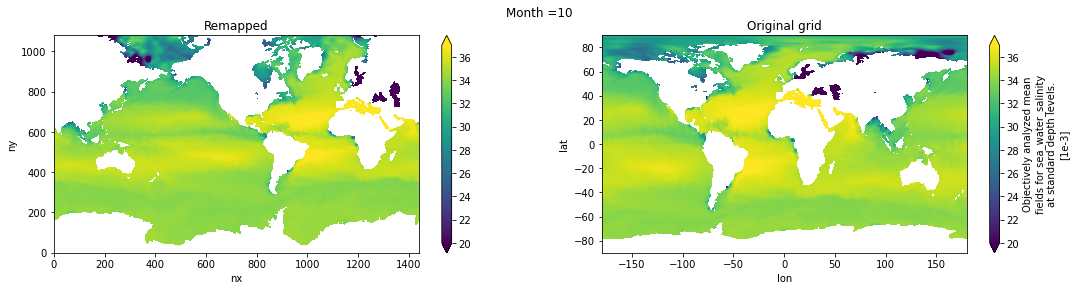

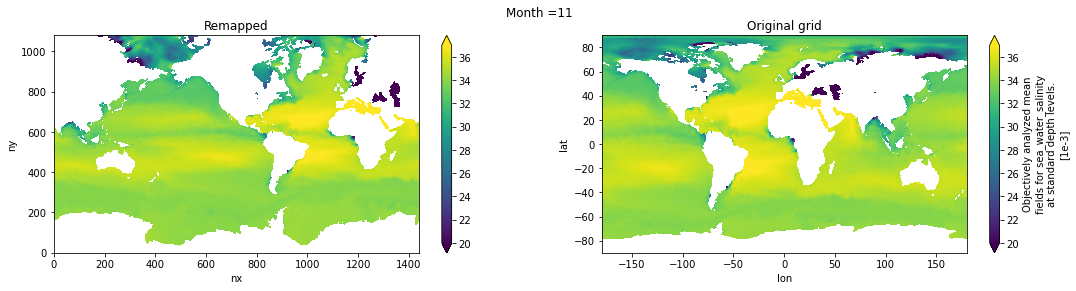

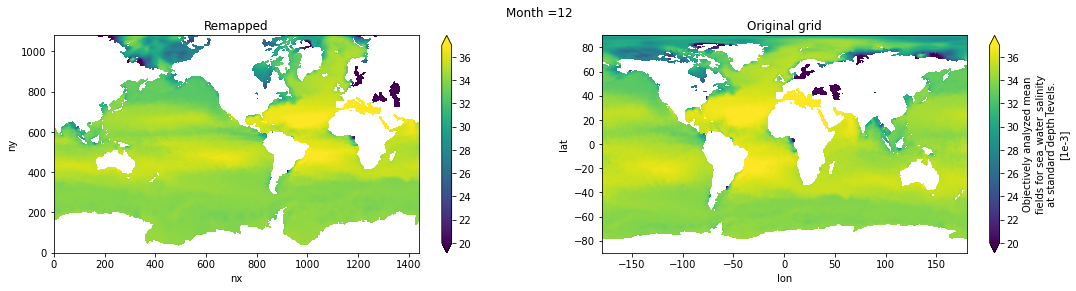

In [9]:
# visual inspection. Make sure original and remapped plots look similar
for t in range(len(temp.time)):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,4))
  salt[t,0,:,:].plot.pcolormesh(ax=axes[0], vmin=20,vmax=37)
  ds_in['s_an'][t,0,:,:].plot.pcolormesh(ax=axes[1], vmin=20,vmax=37)
  axes[0].set_title('Remapped')
  axes[1].set_title('Original grid')
  plt.suptitle('Month ='+ str(t+1))

#### WOA09 layer depths
To keep consistency with previous datasets and to avoid modifying parameter DIAG_COORD_DEF_Z in CESM/MOM6, we will vertically interpolate temp and salt to the 34 layer depths from WOA09

In [10]:
depths_woa09 = np.array([2.5, 10, 20, 32.5, 51.25, 75, 100, 125, 156.25, 200, 250, 312.5, 400,
500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1537.5, 1750,
2062.5, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]);

#### Monthly means

In [11]:
temp_depths_woa09 = temp.interp(depth=depths_woa09).rename('temp')

In [12]:
# Global attrs
temp_depths_woa09.attrs['title'] = 'Potential temperature (monthly mean) from WOA18 remapped to tx1_4 and vertically interpolated to the WOA09 depths.'
temp_depths_woa09.attrs['author'] = 'Gustavo Marques (gmarques@ucar.edu)'
temp_depths_woa09.attrs['date'] = datetime.now().isoformat()
temp_depths_woa09.attrs['infile'] = infile
temp_depths_woa09.attrs['url'] = 'https://github.com/NCAR/tx1_4/woa18'
# save
fname = 'WOA18_TEMP_tx1_4_35lev_monthly_avg.nc'
temp_depths_woa09.to_netcdf(fname)

In [13]:
salt_depths_woa09 = salt.interp(depth=depths_woa09).rename('salt')

In [14]:
# Global attrs
salt_depths_woa09.attrs['title'] = 'Salinity (monthly mean) from WOA18 remapped to tx1_4 and vertically interpolated to the WOA09 depths.'
salt_depths_woa09.attrs['author'] = 'Gustavo Marques (gmarques@ucar.edu)'
salt_depths_woa09.attrs['date'] = datetime.now().isoformat()
salt_depths_woa09.attrs['infile'] = infile
temp_depths_woa09.attrs['url'] = 'https://github.com/NCAR/tx1_4/woa18'
# save
fname = 'WOA18_SALT_tx1_4_35lev_monthly_avg.nc'
salt_depths_woa09.to_netcdf(fname)

#### Annual mean

In [15]:
temp_depths_woa09_ann = temp.mean('time').interp(depth=depths_woa09)#.rename('temp')

In [16]:
# Global attrs
temp_depths_woa09_ann.attrs['title'] = 'Potential temperature from WOA18 (annual mean) remapped to tx1_4 and vertically interpolated to the WOA09 depths.'
temp_depths_woa09_ann.attrs['author'] = 'Gustavo Marques (gmarques@ucar.edu)'
temp_depths_woa09_ann.attrs['date'] = datetime.now().isoformat()
temp_depths_woa09_ann.attrs['infile'] = infile
temp_depths_woa09.attrs['url'] = 'https://github.com/NCAR/tx1_4/woa18'
# save
fname = 'WOA18_TEMP_tx1_4_35lev_ann_avg.nc'
temp_depths_woa09_ann.to_netcdf(fname)

In [17]:
salt_depths_woa09_ann = salt.mean('time').interp(depth=depths_woa09).rename('salt')

In [18]:
# Global attrs
salt_depths_woa09_ann.attrs['title'] = 'Salinity from WOA18 (annual mean) remapped to tx1_4 and vertically interpolated to the WOA09 depths.'
salt_depths_woa09_ann.attrs['author'] = 'Gustavo Marques (gmarques@ucar.edu)'
salt_depths_woa09_ann.attrs['date'] = datetime.now().isoformat()
salt_depths_woa09_ann.attrs['infile'] = infile
temp_depths_woa09.attrs['url'] = 'https://github.com/NCAR/tx1_4/woa18'
# save
fname = 'WOA18_SALT_tx1_4_35lev_ann_avg.nc'
salt_depths_woa09_ann.to_netcdf(fname)